## Travel time to regional hubs
Use Mapbox API to calcuate travel time to major neighboring cities (population greater than 1mil).  
Use district centroids as origins

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from infrasap import mapbox_helper as mb
from shapely.wkt import loads

from dotenv import load_dotenv, find_dotenv

%load_ext autoreload
%autoreload 2

In [2]:
country = 'guatemala'
iso3 = 'GTM'
epsg = 26915

In [3]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
mb_token = os.environ.get("MB_TOKEN")

### Load data

In [4]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")
G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'

In [6]:
target = gpd.read_file(focal_admin2)
target['centroid'] = target.centroid
cities = gpd.read_file(global_cities)

In [12]:
cities_filter = cities.copy()
cities_filter = cities_filter[cities_filter.Pop>500000].copy() # used to be 1 million, but that's not working for CR

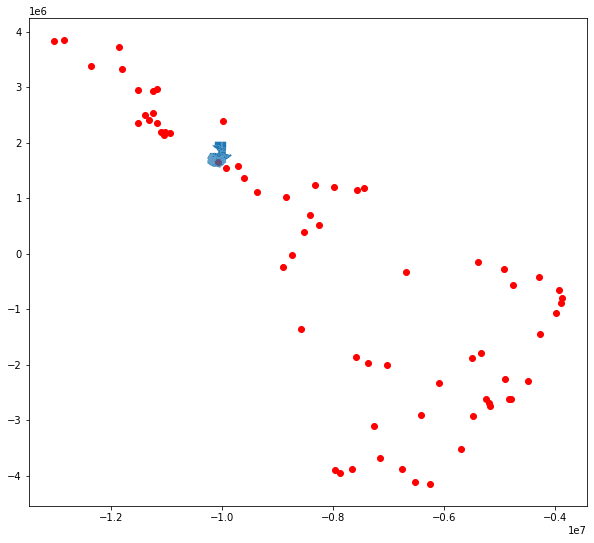

In [13]:
cities_filter = cities_filter.to_crs('EPSG:3857')
target = target.to_crs('EPSG:3857')

ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [14]:
# remove cities that are in the country of interest
adm0 = target.dissolve(by='WB_ADM0_CO')
cities_filter = cities_filter.loc[~cities_filter.intersects(adm0.geometry.iloc[0])]

# sort by distance to country
cities_filter['dist_to_ADM0'] = cities_filter.distance(adm0.centroid.iloc[0])
cities_filter = cities_filter.sort_values('dist_to_ADM0')

In [15]:
# choose destinations based on the nearest N cities. 
# N might change depending on the country, if the cities are too far apart use 5, otherwise the Mapbox requests will break
# If there are many cities close by, use 10
n_nearest = 10
cities_filter = cities_filter.head(n_nearest).to_crs(cities.crs)
target = target.to_crs(cities.crs)
target.crs == cities_filter.crs

True

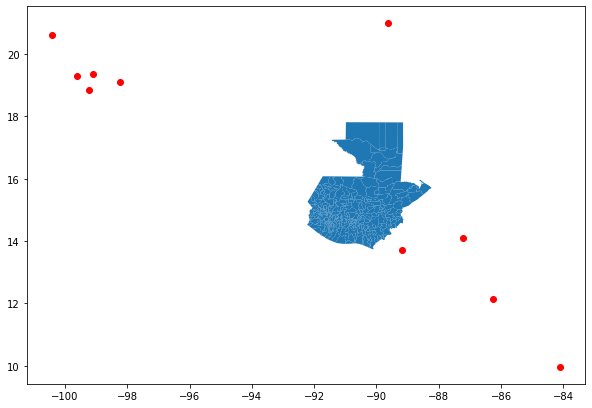

In [16]:
ax = cities_filter.plot(figsize=(10, 10), color='red')
target.plot(figsize=(7, 7), ax=ax)

In [17]:
origins = target.copy()
dests = cities_filter.copy().reset_index(drop=True)

In [18]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

origins['Pop'] = 1
dests['Pop'] = 1

In [19]:
odRes = mb.CreateODMatrix(origins, dests, lat_name = 'y', lon_name = 'x', UID = 'ID',
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = mb_token,
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Thu Aug  6 15:01:38 2020
source list: 335
sources list: 28
dest list: 10
dests list: 1

Estimated remaining calls to chosen server: 28

save points will occur every 1 calls

Call to OSRM server number: 1 of 28
Call to OSRM server number: 2 of 28
Call to OSRM server number: 3 of 28
Call to OSRM server number: 4 of 28
Call to OSRM server number: 5 of 28
Call to OSRM server number: 6 of 28
Call to OSRM server number: 7 of 28
Call to OSRM server number: 8 of 28
Call to OSRM server number: 9 of 28
Call to OSRM server number: 10 of 28
Call to OSRM server number: 11 of 28
Call to OSRM server number: 12 of 28
Call to OSRM server number: 13 of 28
Call to OSRM server number: 14 of 28
Call to OSRM server number: 15 of 28
Call to OSRM server number: 16 of 28
Call to OSRM server number: 17 of 28
Call to OSRM server number: 18 of 28
Call to OSRM server number: 19 of 28
Call to OSRM server number: 20 of 28
Call to OSRM server number: 21 of 28
Call to OSRM server number

In [20]:
odRes.head()

,D_UID,O_UID,DIST,O_POP,D_POP
0,0,15740,16375.4,1,1
1,1,15740,39603.1,1,1
2,2,15740,49973.8,1,1
3,3,15740,70197.8,1,1
4,4,15740,72104.9,1,1


In [21]:
OD_re = odRes.pivot(index='O_UID',columns='D_UID', values='DIST')
OD_re2 = OD_re.apply(lambda x: x/(60*60))

In [22]:
OD_re2.head()

D_UID,0,1,2,3,4,5,6,7,8,9
O_UID,,,,,,,,,,
15740,4.548722,11.000861,13.881611,19.499389,20.029139,18.823833,20.668361,20.218694,21.191778,22.223167
15741,3.938278,10.390417,13.271167,19.532444,19.418694,18.486750,20.331278,19.881611,20.854694,21.886083
15742,4.781306,11.233444,14.114194,19.904361,20.261722,19.329778,21.174306,20.724639,21.697722,22.729111
15743,5.433417,11.538083,14.766306,18.639306,20.913833,19.654111,21.498639,21.048972,22.022056,23.053444
15744,5.271000,11.542944,14.603889,18.644167,20.751417,19.819472,21.664000,21.214333,22.187417,23.218806


In [23]:
# get the min
OD_re3 = pd.DataFrame(OD_re2.idxmin(axis=1), columns=['ID']).join(pd.DataFrame(OD_re2.min(axis=1), columns=['tt_regional']))
# OD_re3 = pd.DataFrame(data=[OD_re2.idxmin(axis=1), OD_re2.min(axis=1)], index=['D_UID','time']).transpose()

In [24]:
OD_re3.head()

,ID,tt_regional
O_UID,,
15740,0,4.548722
15741,0,3.938278
15742,0,4.781306
15743,0,5.433417
15744,0,5.271000


In [25]:
OD_re3['OBJECTID'] = OD_re3.index.astype('int')
target_hubs = target.merge(OD_re3, on='OBJECTID')

Merge back destination hub name

In [26]:
target_hubs['ID'] = target_hubs['ID'].astype('int')

In [27]:
target_hubs2 = target_hubs.merge(dests[['Name','ID']], on='ID') # for LAC cities file change to Name / global file Name1
target_hubs2['Name'].value_counts()

San Salvador               331
Merida                       3
San Felipe Teotlalcingo      1
Name: Name, dtype: int64

In [28]:
target_hubs2.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [29]:
target_hubs2.rename(columns={'tt_regional':'Time (hrs)', 'ID':'Regional Hub ID', 'Name':'Regional Hub Name'}, inplace=True)

In [30]:
output_path = os.path.join(out_folder, 'tables')
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [31]:
target_hubs2.to_excel(os.path.join(output_path, "8Travel Time to Regional Hub.xlsx"), index=False)